In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
# Load the datasets using the specified paths
job_posting = pd.read_csv('./Raw_Data/postings.csv')
companies = pd.read_csv('./Raw_Data/companies/companies.csv')
job_skills = pd.read_csv('./Raw_Data/jobs/job_skills.csv')
mapping_skills = pd.read_csv('./Raw_Data/mappings/skills.csv')

In [3]:
# Companies dataset
companies = companies.astype({
    'company_id': 'Int64',
    'name': 'string',
    'company_size': 'float'
})

# Job postings dataset
job_posting = job_posting.astype({
    'job_id': 'Int64',
    'company_name': 'string',
    'min_salary': 'float'
})

# Job skills dataset
job_skills = job_skills.astype({
    'job_id': 'Int64',
    'skill_abr': 'string'
})

# Mapping skills dataset
mapping_skills = mapping_skills.astype({
    'skill_abr': 'string',
    'skill_name': 'string'
})

In [4]:
# Check for missing values in each DataFrame
missing_values_companies = companies.isnull().sum()
missing_values_job_skills = job_skills.isnull().sum()
missing_values_skills = mapping_skills.isnull().sum()
missing_values_postings = job_posting.isnull().sum()

In [5]:
# Display summaries of missing values after handling for verification
print("Missing values in companies:\n", missing_values_companies)
print("\nMissing values in job_skills:\n", missing_values_job_skills)
print("\nMissing values in mapping_skills:\n", missing_values_skills)
print("\nMissing values in job_posting:\n", missing_values_postings)


Missing values in companies:
 company_id         0
name               0
description      296
company_size    2774
state             22
country            0
city               1
zip_code          28
address           22
url                0
dtype: int64

Missing values in job_skills:
 job_id       0
skill_abr    0
dtype: int64

Missing values in mapping_skills:
 skill_abr     0
skill_name    0
dtype: int64

Missing values in job_posting:
 job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job

In [6]:
# Merge job_skills with mapping_skills to include full skill names
job_skills_detailed = job_skills.merge(mapping_skills, on="skill_abr", how="left")
# Display the first few rows of the merged data for verification
job_skills_detailed.head()

,job_id,skill_abr,skill_name
0,3884428798,MRKT,Marketing
1,3884428798,PR,Public Relations
2,3884428798,WRT,Writing/Editing
3,3887473071,SALE,Sales
4,3887465684,FIN,Finance


In [20]:
# Fill missing values in the companies DataFrame
fill_values = {
    'company_size': companies['company_size'].median(),
    'description': "No description provided",
    'state': "Unknown",
    'city': "Unknown",
    'zip_code': "Unknown",
    'address': "Unknown"
}

for column, value in fill_values.items():
    companies[column] = companies[column].fillna(value)

job_posting.fillna({'company_name': 'Unknown'})
job_posting.fillna({'description': 'No description provided'})


# Drop rows in job_posting where 'company_id' is missing
job_posting.dropna(subset=['company_id'], inplace=True)

# Convert 'company_id' to nullable integer to avoid float conversion
job_posting['company_id'] = job_posting['company_id'].astype('Int64')


In [21]:
# Print initial missing values in postings
print("Initial missing values in postings:\n", job_posting.isnull().sum())



Initial missing values in postings:
 job_id                            0
company_name                      2
title                             0
description                       6
max_salary                        0
pay_period                    86568
location                          0
company_id                        0
views                          1627
min_salary                        0
formatted_work_type               0
applies                       99236
original_listed_time              0
application_type                  0
expiry                            0
formatted_experience_level    27949
listed_time                       0
posting_domain                38252
sponsored                         0
work_type                         0
currency                      86568
compensation_type             86568
normalized_salary             86568
salary_range                      0
salary_range_category          1996
season                            0
is_full_time               

In [22]:
# Calculate median salary values for filling
salary_median = job_posting[['max_salary', 'min_salary']].median()
job_posting['max_salary'] = job_posting['max_salary'].fillna(salary_median['max_salary'])
job_posting['min_salary'] = job_posting['min_salary'].fillna(salary_median['min_salary'])

# Drop columns with too many missing values (over 80% missing)
columns_to_drop = ['med_salary', 'skills_desc', 'remote_allowed', 'closed_time','zip_code', 'fips', 'job_posting_url', 'application_url']
job_posting = job_posting.drop(columns=columns_to_drop, errors='ignore')


In [23]:
# Integration Step
job_data_combined = job_posting.merge(job_skills_detailed, on="job_id", how="left")
job_data_combined['company_id'] = job_data_combined['company_id'].astype('Int64')  # Ensure alignment with companies

# Now merge job_data_combined with companies on 'company_id' to include company information
full_data = job_data_combined.merge(companies, on="company_id", how="left")

# Check final missing values in full_data
print("Final missing values in full_data:\n", full_data.isnull().sum())


Final missing values in full_data:
 job_id                             0
company_name                       4
title                              0
description_x                     11
max_salary                         0
pay_period                    144438
location                           0
company_id                         0
views                           2802
min_salary                         0
formatted_work_type                0
applies                       165087
original_listed_time               0
application_type                   0
expiry                             0
formatted_experience_level     45677
listed_time                        0
posting_domain                 66789
sponsored                          0
work_type                          0
currency                      144438
compensation_type             144438
normalized_salary             144438
salary_range                       0
salary_range_category           3425
season                             0
is

In [24]:
# Aggregation examples
job_count_per_company = full_data.groupby("company_id")['job_id'].count().reset_index()
job_count_per_company.rename(columns={"job_id": "total_jobs"}, inplace=True)
job_count_per_company = job_count_per_company.merge(companies[['company_id', 'name']], on='company_id', how='left')

print("Total job postings per company:\n", job_count_per_company[['name', 'total_jobs']].head())


Total job postings per company:
                          name  total_jobs
0                         IBM          33
1               GE HealthCare          85
2  Hewlett Packard Enterprise          24
3                      Oracle         127
4                   Accenture          37


In [25]:
skill_count = job_skills_detailed['skill_name'].value_counts().reset_index()
skill_count.columns = ['skill_name', 'count']
print("Top required skills across all jobs:\n", skill_count.head())

Top required skills across all jobs:
                skill_name  count
0  Information Technology  26137
1                   Sales  22475
2              Management  20861
3           Manufacturing  18185
4    Health Care Provider  17369


In [26]:
# Drop duplicates
full_data.drop_duplicates(inplace=True)

In [27]:
# Final sampling step
sampled_data = full_data.sample(frac=0.05, random_state=42).copy()
print("\nSample of fully processed data:\n", sampled_data.head())


Sample of fully processed data:
             job_id                                   company_name  \
179699  3905351309                           Signature HealthCARE   
20013   3887593646                           Keck Medicine of USC   
23240   3887872935                                        Netflix   
151463  3904577325  TMAC's Direct Hire (Executive Search) Service   
131876  3903840980                             FirstChoice Hiring   

                                                    title  \
179699                  Certified Nursing Assistant (CNA)   
20013   Licensed Vocational Nurse - Emergency Room - F...   
23240   Technical Program Manager 6 - Game SDK and Ser...   
151463     Field Medical Director, Pediatric Gene Editing   
131876       HVAC Technicians / Installers - Capital Heat   

                                            description_x  max_salary  \
179699  About Us\n\nWelcome to Signature Healthcare of...     80000.0   
20013   The Licensed Vocational Nurse 

In [28]:
# First, create the salary range and category if not already created
job_posting['salary_range'] = job_posting['max_salary'] - job_posting['min_salary']
job_posting['salary_range_category'] = pd.cut(job_posting['salary_range'], bins=[0, 20000, 50000, 100000], labels=['Low', 'Medium', 'High'])

# Select and print company name, salary details, and the salary range category
print(job_posting[['company_name', 'min_salary', 'max_salary', 'salary_range_category']].head())


                company_name  min_salary  max_salary salary_range_category
0      Corcoran Sawyer Smith        17.0        20.0                   Low
2     The National Exemplar      45000.0     65000.0                   Low
3     Abrams Fensterman, LLP    140000.0    175000.0                Medium
5  Downtown Raleigh Alliance        14.0        20.0                   Low
6                 Raw Cereal     60000.0    300000.0                   NaN


In [29]:

# Assuming 'listed_time' is in milliseconds, convert it to datetime
job_posting['original_listed_time'] = pd.to_datetime(job_posting['original_listed_time'], unit='ms')


# Function to categorize seasons based on month
def get_season(date):
    if date.month in [12, 1, 2]:  # December to February
        return 'Winter'
    elif date.month in [3, 4, 5]:  # March to May
        return 'Spring'
    elif date.month in [6, 7, 8]:  # June to August
        return 'Summer'
    else:  # September to November
        return 'Fall'

# Apply the function to create a new column 'season'
job_posting['season'] = job_posting['original_listed_time'].apply(get_season)

# Display random entries with styled output
random_sample = job_posting[['original_listed_time', 'season']].sample(n=10, random_state=1).style.set_table_attributes('style="width: 50%; margin: auto;"').set_caption("Random Job Postings with Original Listed Time and Season")

# Render the styled output
random_sample


,original_listed_time,season
46016,2024-04-17 22:26:32,Spring
88336,2024-04-17 23:02:56,Spring
71548,2024-04-19 00:00:00,Spring
101909,2024-04-18 19:44:54,Spring
31934,2024-04-11 16:59:46,Spring
119893,2024-04-19 21:29:14,Spring
80520,2024-04-18 00:00:00,Spring
16444,2024-04-05 00:00:00,Spring
23081,2024-04-09 12:39:56,Spring
24392,2024-04-11 17:56:35,Spring


In [30]:
# Define all seasons with initial count of zero
all_seasons = {"Winter": 0, "Spring": 0, "Summer": 0, "Fall": 0}

# Count occurrences of each season in the 'expiry' column
season_counts = job_posting['season'].value_counts().to_dict()

# Update the all_seasons dictionary with actual counts
all_seasons.update(season_counts)

# Display the complete season counts including Winter
print("\nOriginal Listed Time  Date Counts by Season")
for season, count in all_seasons.items():
    print(f"{season}: {count}")


Original Listed Time  Date Counts by Season
Winter: 16
Spring: 122116
Summer: 0
Fall: 0


In [31]:
# Create the is_full_time column if not already created
job_posting['is_full_time'] = job_posting['work_type'].apply(lambda x: 1 if x == 'Full-Time' else 0)

# Select and print company name and the is_full_time indicator
print(job_posting[['company_name', 'is_full_time']].head())


                company_name  is_full_time
0      Corcoran Sawyer Smith             0
2     The National Exemplar              0
3     Abrams Fensterman, LLP             0
5  Downtown Raleigh Alliance             0
6                 Raw Cereal             0


In [32]:
# Zgjedhja e veçorive numerike për PCA
features = job_posting[['max_salary', 'min_salary', 'views', 'applies']]

# Imputimi i vlerave të humbura
imputer = SimpleImputer(strategy='median')
features_imputed = imputer.fit_transform(features)

# Normalizimi i të dhënave
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Aplikimi i PCA
pca = PCA(n_components=2)  # Zgjedhja e dy përbërësve
principal_components = pca.fit_transform(features_scaled)

# Krijimi i DataFrame për përbërësit
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])

# Shtimi i kolonave origjinale për identifikim
pca_df['job_id'] = job_posting['job_id']
pca_df['company_name'] = job_posting['company_name']

# Shfaqja e rezultatit
print(pca_df)

            PCA1      PCA2      job_id                      company_name
0      -0.346517 -0.085717      921716             Corcoran Sawyer Smith
1      -0.084540 -0.130993        <NA>                              <NA>
2       0.414807 -0.067497    10998357            The National Exemplar 
3      -0.346875 -0.066296    23221523            Abrams Fensterman, LLP
4       0.438256 -0.252185        <NA>                              <NA>
...          ...       ...         ...                               ...
122127  0.397005 -0.191231  3906251986                 BAE Systems, Inc.
122128 -0.010333 -0.172640  3906251989                 BAE Systems, Inc.
122129 -0.010333 -0.172640  3906251990                 BAE Systems, Inc.
122130 -0.010273 -0.164386  3906251999                      Job Juncture
122131  0.007687 -0.180980  3906252016  K&A Engineering Consulting, P.C.

[122132 rows x 4 columns]


In [18]:
# Create a new folder named 'processed_data' (you can choose any name)
folder_name = 'Processed_data'
os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist
# Save the preprocessed data to a new CSV file in the created folder
job_posting.to_csv(os.path.join(folder_name, 'preprocessed_job_postings.csv'), index=False)
companies.to_csv(os.path.join(folder_name, 'companies.csv'), index=False)
job_skills.to_csv(os.path.join(folder_name, 'job_skills.csv'), index=False)
mapping_skills.to_csv(os.path.join(folder_name, 'mapping_skills.csv'), index=False)


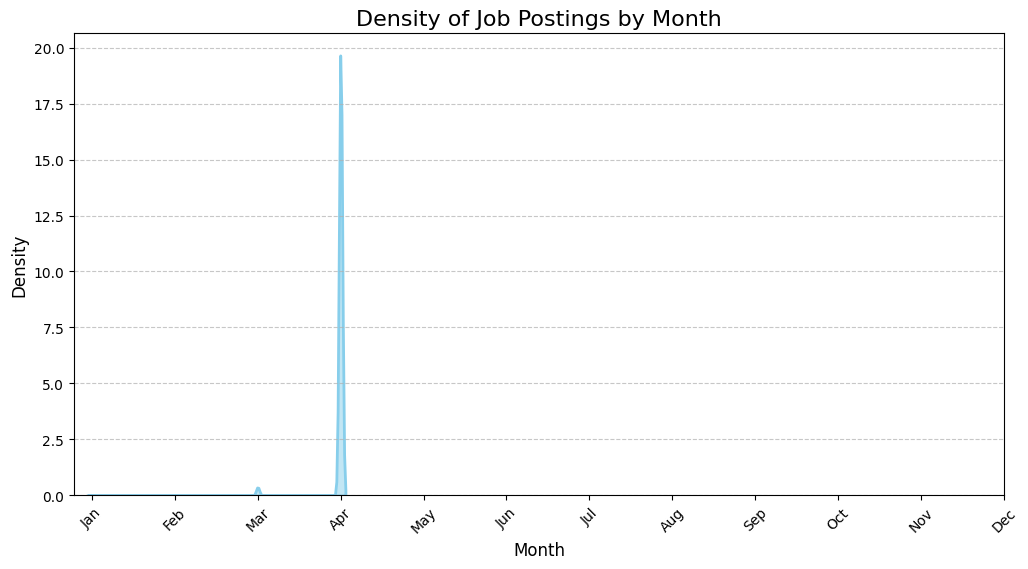

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'original_listed_time' is in datetime format
job_posting['original_listed_time'] = pd.to_datetime(job_posting['original_listed_time'], unit='ms')

# Extract the month from 'original_listed_time'
job_posting['month'] = job_posting['original_listed_time'].dt.month

# Plot the density of job postings by month
plt.figure(figsize=(12, 6))
sns.kdeplot(data=job_posting, x='month', fill=True, alpha=0.5, linewidth=2, color='skyblue')
plt.title('Density of Job Postings by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




In [12]:
# Detect outliers using IQR
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply to salary columns
job_posting = remove_outliers_iqr(job_posting, ['min_salary', 'max_salary'])

# Verify remaining rows
print(job_posting[['min_salary', 'max_salary']].describe())


          min_salary     max_salary
count   29322.000000   29322.000000
mean    59046.888252   81969.727983
std     55650.299135   78648.676435
min         1.000000       1.000000
25%        35.000000      47.000000
50%     60000.000000   80000.000000
75%     98712.500000  135000.000000
max    249645.000000  340100.000000


          min_salary     max_salary
count   18272.000000   18272.000000
mean    94435.614405  130880.521156
std     40053.829313   58667.052411
min     10000.000000   12000.000000
25%     65000.000000   85000.000000
50%     86840.000000  120000.000000
75%    120000.000000  165000.000000
max    245000.000000  337250.000000


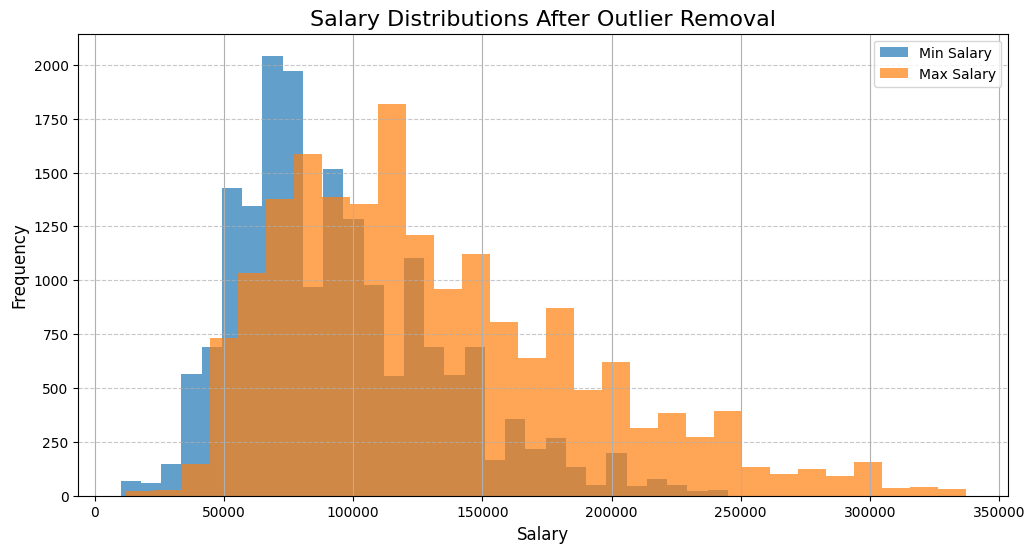

In [13]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter outliers for min_salary and max_salary
job_posting = remove_outliers_iqr(job_posting, 'min_salary')
job_posting = remove_outliers_iqr(job_posting, 'max_salary')

# Remove salaries below a reasonable threshold
min_salary_threshold = 10000
job_posting = job_posting[job_posting['min_salary'] >= min_salary_threshold]

# Display summary statistics after cleaning
print(job_posting[['min_salary', 'max_salary']].describe())

# Optional: Plot the distributions to visualize the impact of outlier removal
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
job_posting['min_salary'].hist(bins=30, alpha=0.7, label='Min Salary')
job_posting['max_salary'].hist(bins=30, alpha=0.7, label='Max Salary')
plt.title('Salary Distributions After Outlier Removal', fontsize=16)
plt.xlabel('Salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
